In [33]:
import pymc3 as pm
from theano import tensor as T
import numpy as np
import matplotlib.pyplot as plt

In [132]:
import lda

In [146]:
from scipy import sparse

## Try to implement our LDA variant in PyMC3

### Get data from previous work

In [144]:
all_eth_train_x = np.load("/Users/tingchen/Desktop/Yelp Project/data/X_train.npy", allow_pickle=True)
all_eth_train_y = np.load("/Users/tingchen/Desktop/Yelp Project/data/y_train.npy", allow_pickle=True)

In [133]:
model = lda.LDA(n_topics=20, n_iter=1500, random_state=1)

In [149]:
X_train = sparse.load_npz("/Users/tingchen/Desktop/Yelp Project/data/X_train.npz")

In [152]:
model.fit(X_train.astype(int))

INFO:lda:n_documents: 1690320
INFO:lda:vocab_size: 634047
INFO:lda:n_words: 128999721
INFO:lda:n_topics: 20
INFO:lda:n_iter: 1500
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -1354042155
INFO:lda:<10> log likelihood: -1139610645
INFO:lda:<20> log likelihood: -1070917818
INFO:lda:<30> log likelihood: -1043892125
INFO:lda:<40> log likelihood: -1029484246
INFO:lda:<50> log likelihood: -1020366950
INFO:lda:<60> log likelihood: -1014548182
INFO:lda:<70> log likelihood: -1011142482
INFO:lda:<80> log likelihood: -1008985824
INFO:lda:<90> log likelihood: -1007539336
INFO:lda:<100> log likelihood: -1006629087
INFO:lda:<110> log likelihood: -1005910675
INFO:lda:<120> log likelihood: -1005

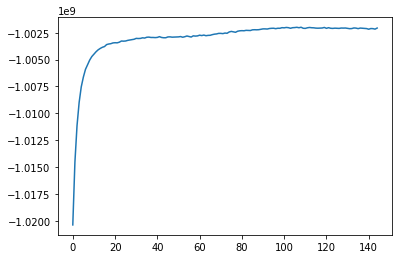

In [156]:
plt.plot(model.loglikelihoods_[5:])
plt.show()

In [158]:
topic_word = model.topic_word_ 

In [164]:
topic_word[2][0]

0.0057817513244842415

### Create model

Create log likelihood function

In [ ]:
def logp_lda_doc(beta, theta):
    """Returns the log-likelihood function for given documents.

    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)

    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions.
    theta : tensor (D x K)
        Topic distributions for documents.
    """
    def ll_docs_f(docs):
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        ll_docs = vfreqs * pmmath.logsumexp(
            tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()

        # Per-word log-likelihood times num of tokens in the whole dataset
        return tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens

    return ll_docs_f

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


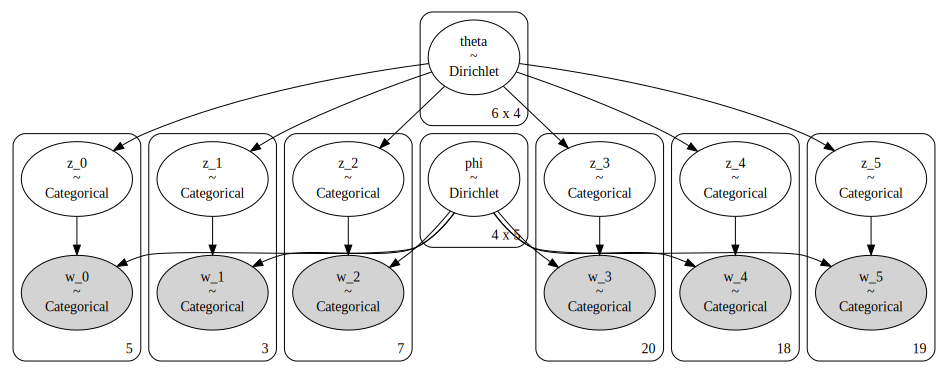

In [121]:
dummy_input = np.array([
                       [0, 0, 1, 2, 2],
                       [0, 0, 1, 1, 1],
                       [0, 1, 2, 2, 2],
                       [4, 4, 4, 4, 4],
                       [3, 3, 4, 4, 4],
                       [3, 4, 4, 4, 4]])

n_topics = 4
n_docs, n_words = dummy_input.shape
doc_lens = np.sum(dummy_input, axis=1)

data = []

for i in range(n_docs):
    doc = []
    for j in range(n_words):
        doc += [j] *dummy_input[i, j]
    
    data += [doc]

with pm.Model() as model:
    alpha = pm.floatX(.01)
    beta = pm.floatX(.01)
    
    # prior on topic mixture
    theta = pm.Dirichlet('theta', a= alpha* np.ones(n_topics),
                      shape=(n_docs, n_topics))
    
    # prior on word distributions
    phi = pm.Dirichlet('phi', a= beta * np.ones(n_words),
                      shape=(n_topics, n_words))
    
    # draw topic 
    z = [pm.Categorical('z_'+str(i), p= theta[i], shape = doc_lens[i]) 
         for i in range(n_docs)]
    
    # draw word 
    w = [pm.Categorical('w_'+str(i), p= phi[z[i]], shape = doc_lens[i], observed=data[i]) 
         for i in range(n_docs)]
    
    #doc = pm.DensityDist('doc', logp_lda_doc(beta, theta), observed=doc_t)

pm.model_to_graphviz(model)

With 3 topics

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [phi]
>>Metropolis: [theta]
>CategoricalGibbsMetropolis: [z_5, z_4, z_3, z_2, z_1, z_0]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequ

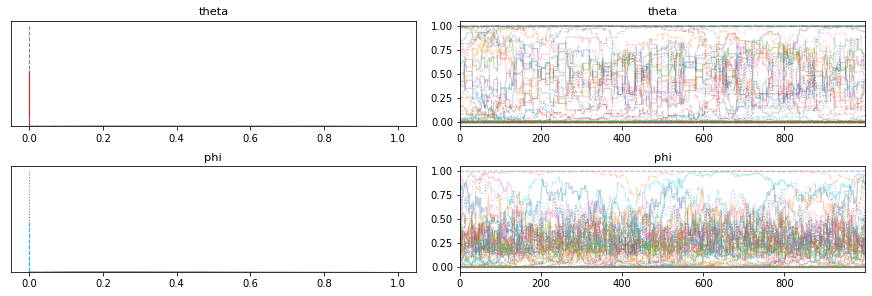

In [129]:
with model:
    #zs= [z_0, z_1, z_2, z_3, z_4, z_5]
    tr = pm.sample(1000, tune=3000, step=[pm.Metropolis([theta, phi])])
    
pm.plots.traceplot(tr, ['theta', 'phi']);

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/arviz/plots/plot_utils.py:563: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (116) in plot_posterior, generating only 40 plots
  UserWarning,


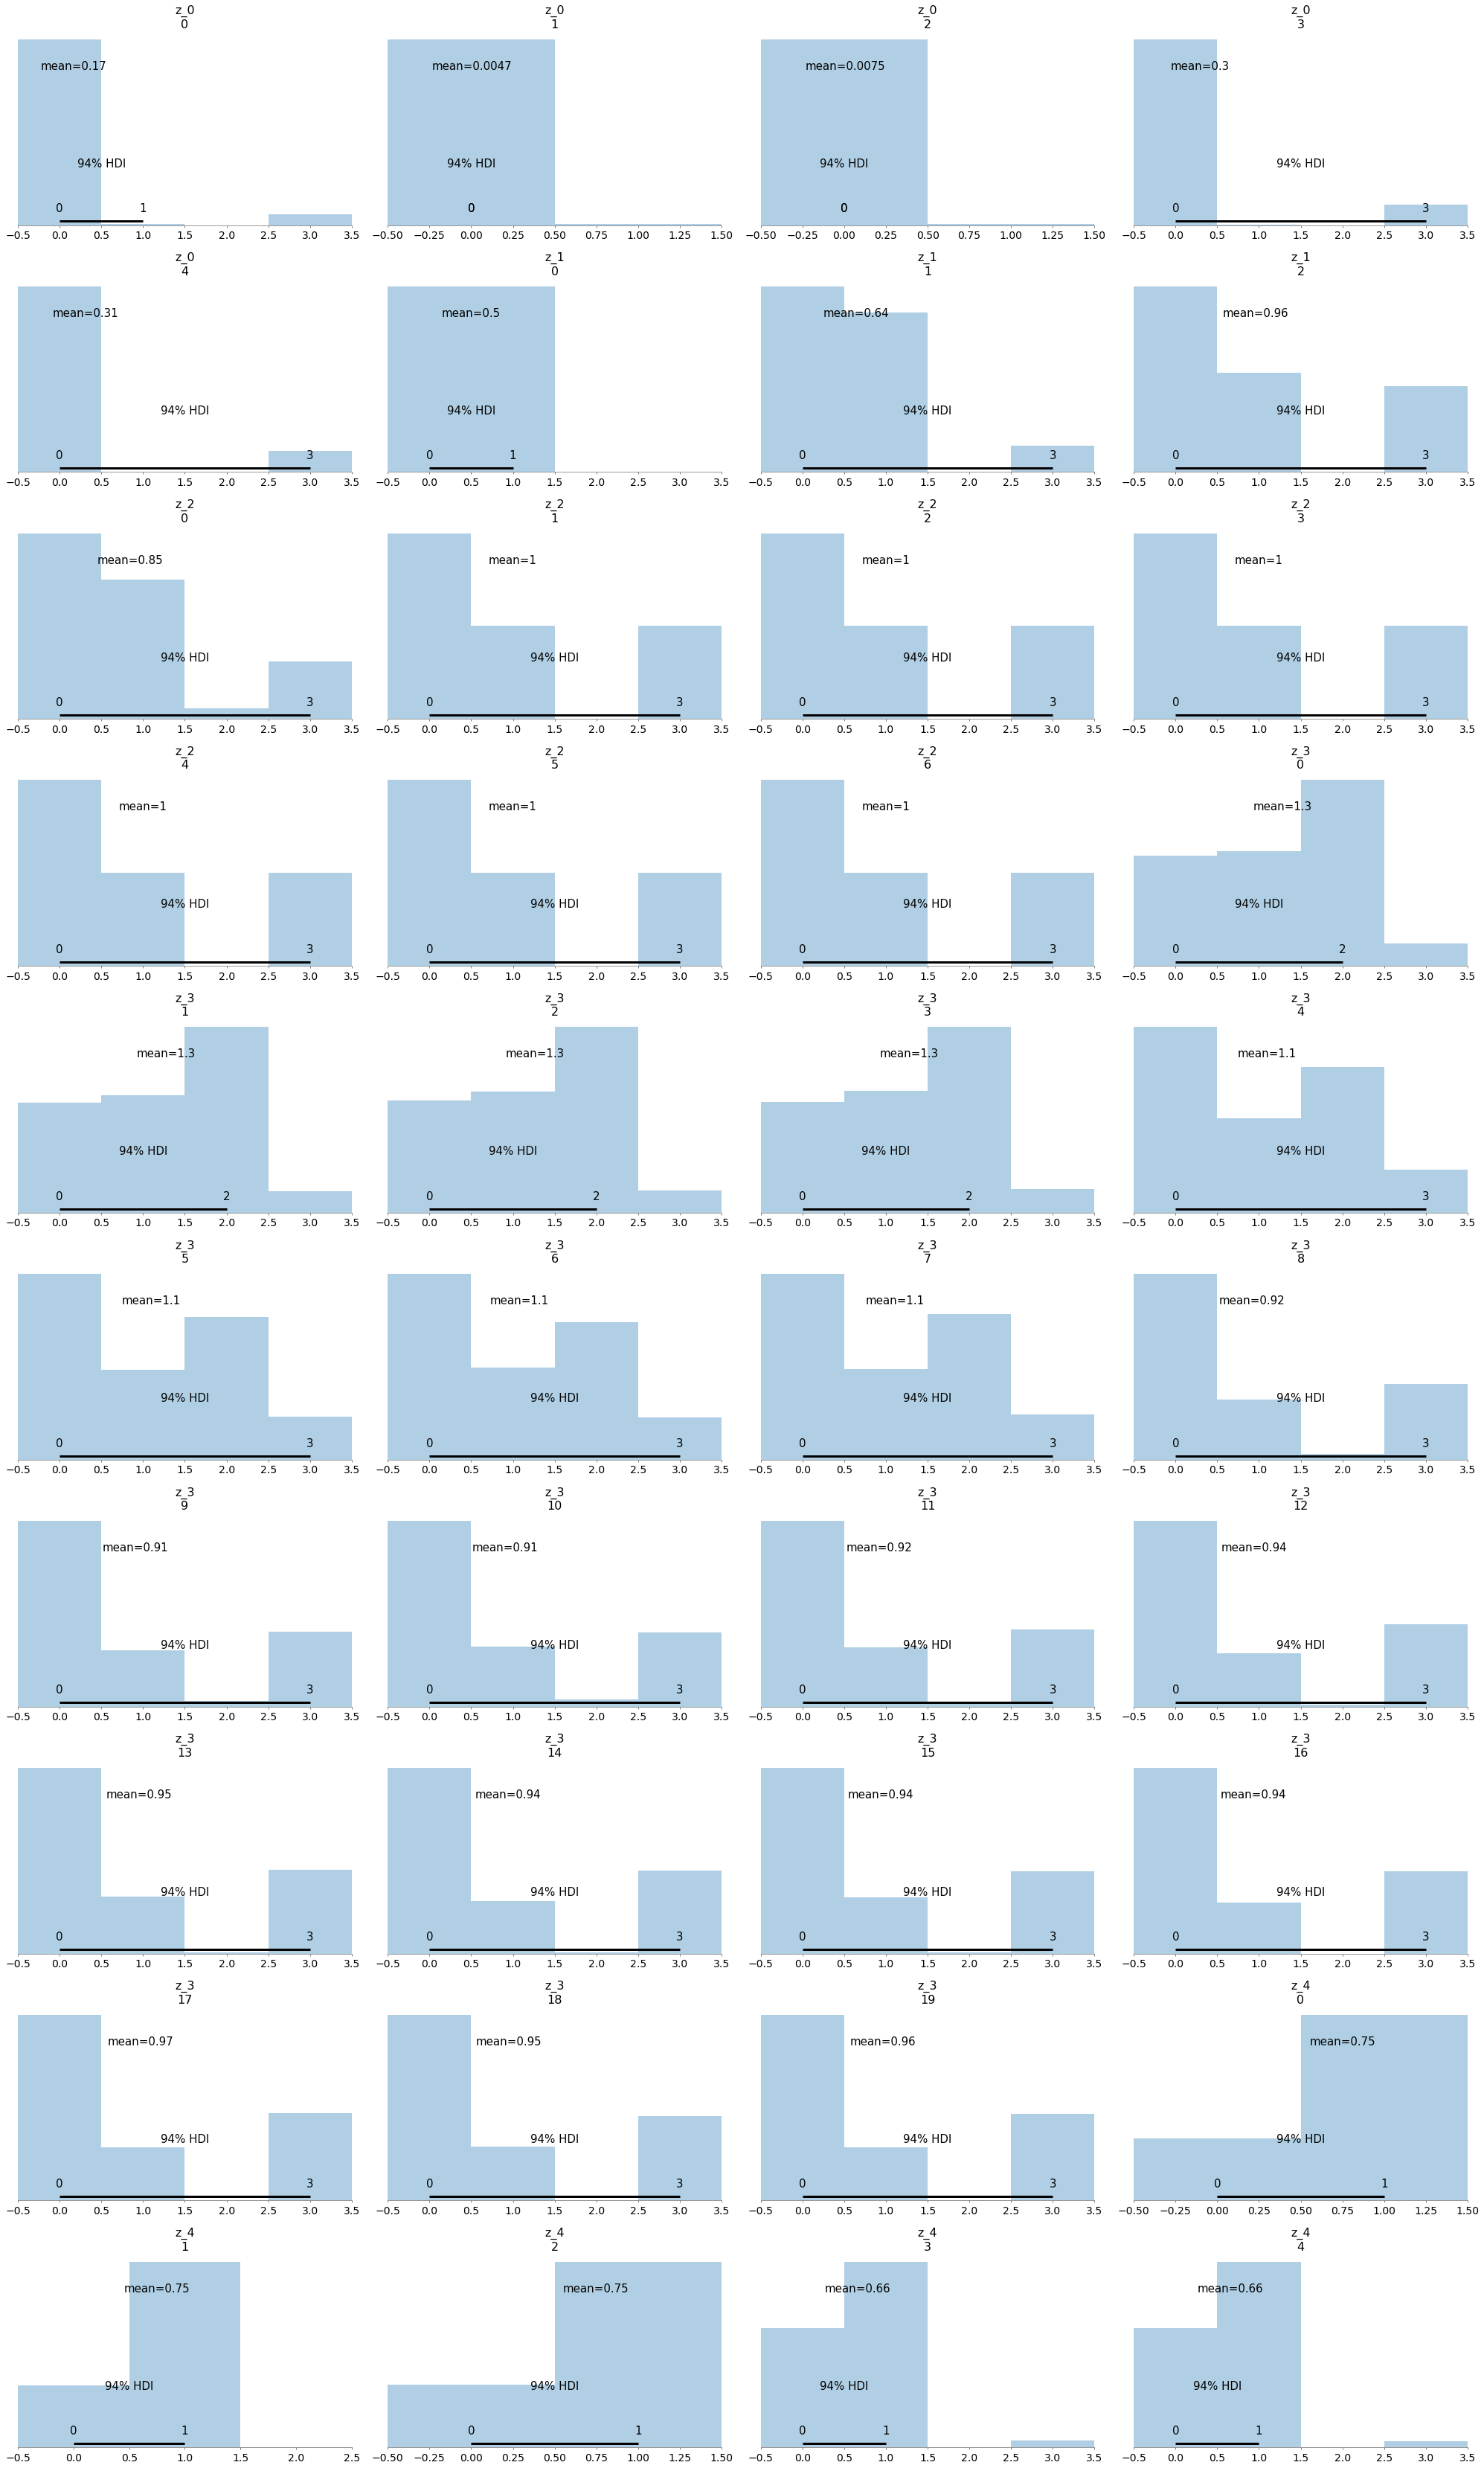

In [130]:
pm.plot_posterior(tr);